In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.randn(X.shape) > dropout).float() # mask 不加上 float 的話，會是一堆的 True, False
    return mask * X / (1. - dropout)

In [ ]:
shape = (1, 2, 3)
mask = torch.randn(shape) > 0.5

In [24]:
class NormalNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        
        super(NormalNet, self).__init__()
        self.num_inputs = num_inputs
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    
        self.var1 = []
        self.var2 = []
        
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape(-1, self.num_inputs)))
        self.var1.append(torch.var(H1.detach(), dim=1).mean())
        
        H2 = self.relu(self.lin2(H1))
        self.var2.append(torch.var(H2.detach(), dim=1).mean())
        
        out = self.lin3(H2)
        return out

In [3]:
dropout1, dropout2 = 0.8, 0.8

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    
        self.var1 = []
        self.var2 = []
        print('training:', self.training)
        
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape(-1, self.num_inputs)))
        if self.training:
            H1 = dropout_layer(H1, dropout=dropout1)
        self.var1.append(torch.var(H1.detach(), dim=1).mean())
        
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, dropout=dropout2)
        self.var2.append(torch.var(H2.detach(), dim=1).mean())
        
        out = self.lin3(H2)
        return out

In [41]:
dropout1, dropout2 = 0.5, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.dropout1 = nn.Dropout(p=dropout1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.dropout2 = nn.Dropout(p=dropout2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    
        self.var1 = []
        self.var2 = []
        print('training:', self.training)
        
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape(-1, self.num_inputs)))
        H1 = self.dropout1(H1)
        self.var1.append(torch.var(H1.detach(), dim=1).mean())
        
        H2 = self.relu(self.lin2(H1))
        H2 = self.dropout2(H2)
        self.var2.append(torch.var(H2.detach(), dim=1).mean())
        
        out = self.lin3(H2)
        return out

train_loss: 0.3395546184539795, train_acc: 0.8747666666666667, test_acc:0.8438


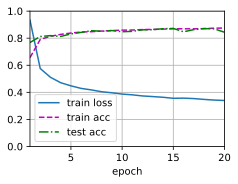

In [42]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True)
# net = NormalNet(num_inputs, num_outputs, num_hiddens1, num_hiddens2)
net.train()
num_epochs, lr, batch_size = 20, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

train_loss: 0.3757597909609477, train_acc: 0.8621166666666666, test_acc:0.8622


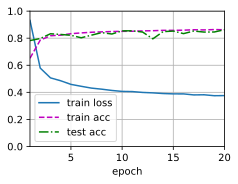

In [46]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True)
net.train()
num_epochs, lr, batch_size = 20, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.0005)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [30]:
# use dropout
# dropout1 = 0.8, dropout2 = 0.8
net.eval()
net.var1, net.var2 = [], []
d2l.evaluate_accuracy(net, test_iter)
sum(net.var1) / len(net.var1), sum(net.var2) / len(net.var2)

(tensor(0.3296), tensor(0.5144))

In [35]:
# use dropout
# dropout1 = 0.5, dropout2 = 0.5
net.eval()
net.var1, net.var2 = [], []
d2l.evaluate_accuracy(net, test_iter)
sum(net.var1) / len(net.var1), sum(net.var2) / len(net.var2)

(tensor(0.1622), tensor(0.1972))

In [39]:
# use dropout
# dropout1 = 0.2, dropout2 = 0.5
net.eval()
net.var1, net.var2 = [], []
d2l.evaluate_accuracy(net, test_iter)
sum(net.var1) / len(net.var1), sum(net.var2) / len(net.var2)

(tensor(0.1430), tensor(0.1553))

In [32]:
# do not use dropout
net.eval()
net.var1, net.var2 = [], []
d2l.evaluate_accuracy(net, test_iter)
sum(net.var1) / len(net.var1), sum(net.var2) / len(net.var2)

(tensor(0.2270), tensor(0.2114))

In [40]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):

    """Train a model (defined in Chapter 3)."""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        net.train()
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
        net.eval()
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    print(f'train_loss: {train_loss}, train_acc: {train_acc}, test_acc:{test_acc}')

In [ ]:
net.var1, net.var2 = [], []
d2l.evaluate_accuracy(net, test_iter)

In [20]:
net.var1

[tensor(0.3059),
 tensor(0.2969),
 tensor(0.2838),
 tensor(0.3304),
 tensor(0.2772),
 tensor(0.3171),
 tensor(0.2941),
 tensor(0.3601),
 tensor(0.2858),
 tensor(0.3456),
 tensor(0.3230),
 tensor(0.2891),
 tensor(0.2879),
 tensor(0.2705),
 tensor(0.2808),
 tensor(0.3207),
 tensor(0.3156),
 tensor(0.3598),
 tensor(0.2818),
 tensor(0.3122),
 tensor(0.3039),
 tensor(0.2919),
 tensor(0.3138),
 tensor(0.3590),
 tensor(0.3026),
 tensor(0.3097),
 tensor(0.2830),
 tensor(0.3259),
 tensor(0.3133),
 tensor(0.3058),
 tensor(0.3030),
 tensor(0.2768),
 tensor(0.3278),
 tensor(0.3772),
 tensor(0.3055),
 tensor(0.3088),
 tensor(0.3009),
 tensor(0.3106),
 tensor(0.3410),
 tensor(0.4417)]